# Predictive Financial Modeling
## LSTM

`-- Leo Lonzarich, 12 January 2022 // [Updated 6-3-23] --`


### Table of Contents
- [Importing Stock Data](#import)
    - [Beta Calculation](#beta)
- [LSTM Model](#lstmmodel)
    - [Preprocessing](#preprocessing)
    - [Building](#build)
    - [Training](#train)
    - [Predictions](#preds)



### General Comments

- Using Long Short Term Memory (LSTM), an artificial recurrent neural network, to predict closing future stock closing performance.
    - LSTM works best when handeling large-scale datasets like these.
<br><br>
- Selecting past 60 to make next-day predictions.
- Credit to ML tutorial of @`Computer Science` on YT.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

# Yahoo API may have broken previous versions of pd_datareader, so this is a workaround.
yfin.pdr_override()

## Importing Data:<a class="anchor" id="import"></a>
---

In [24]:
# Yahoo Finance stock scraping.
# **Careful with how many times you run this to avoid IP ban**
tickr = 'GOOG'
start = dt.datetime(2012, 1, 1)
end = dt.datetime.today()

stock = pdr.get_data_yahoo(tickr, start, end).rename(columns= {'Adj Close': 'AdjClose'})

print(stock.shape[0], "unique points loaded with attributes: \n", stock.
      keys())

[*********************100%***********************]  1 of 1 completed
2805 unique points loaded with attributes: 
 Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')


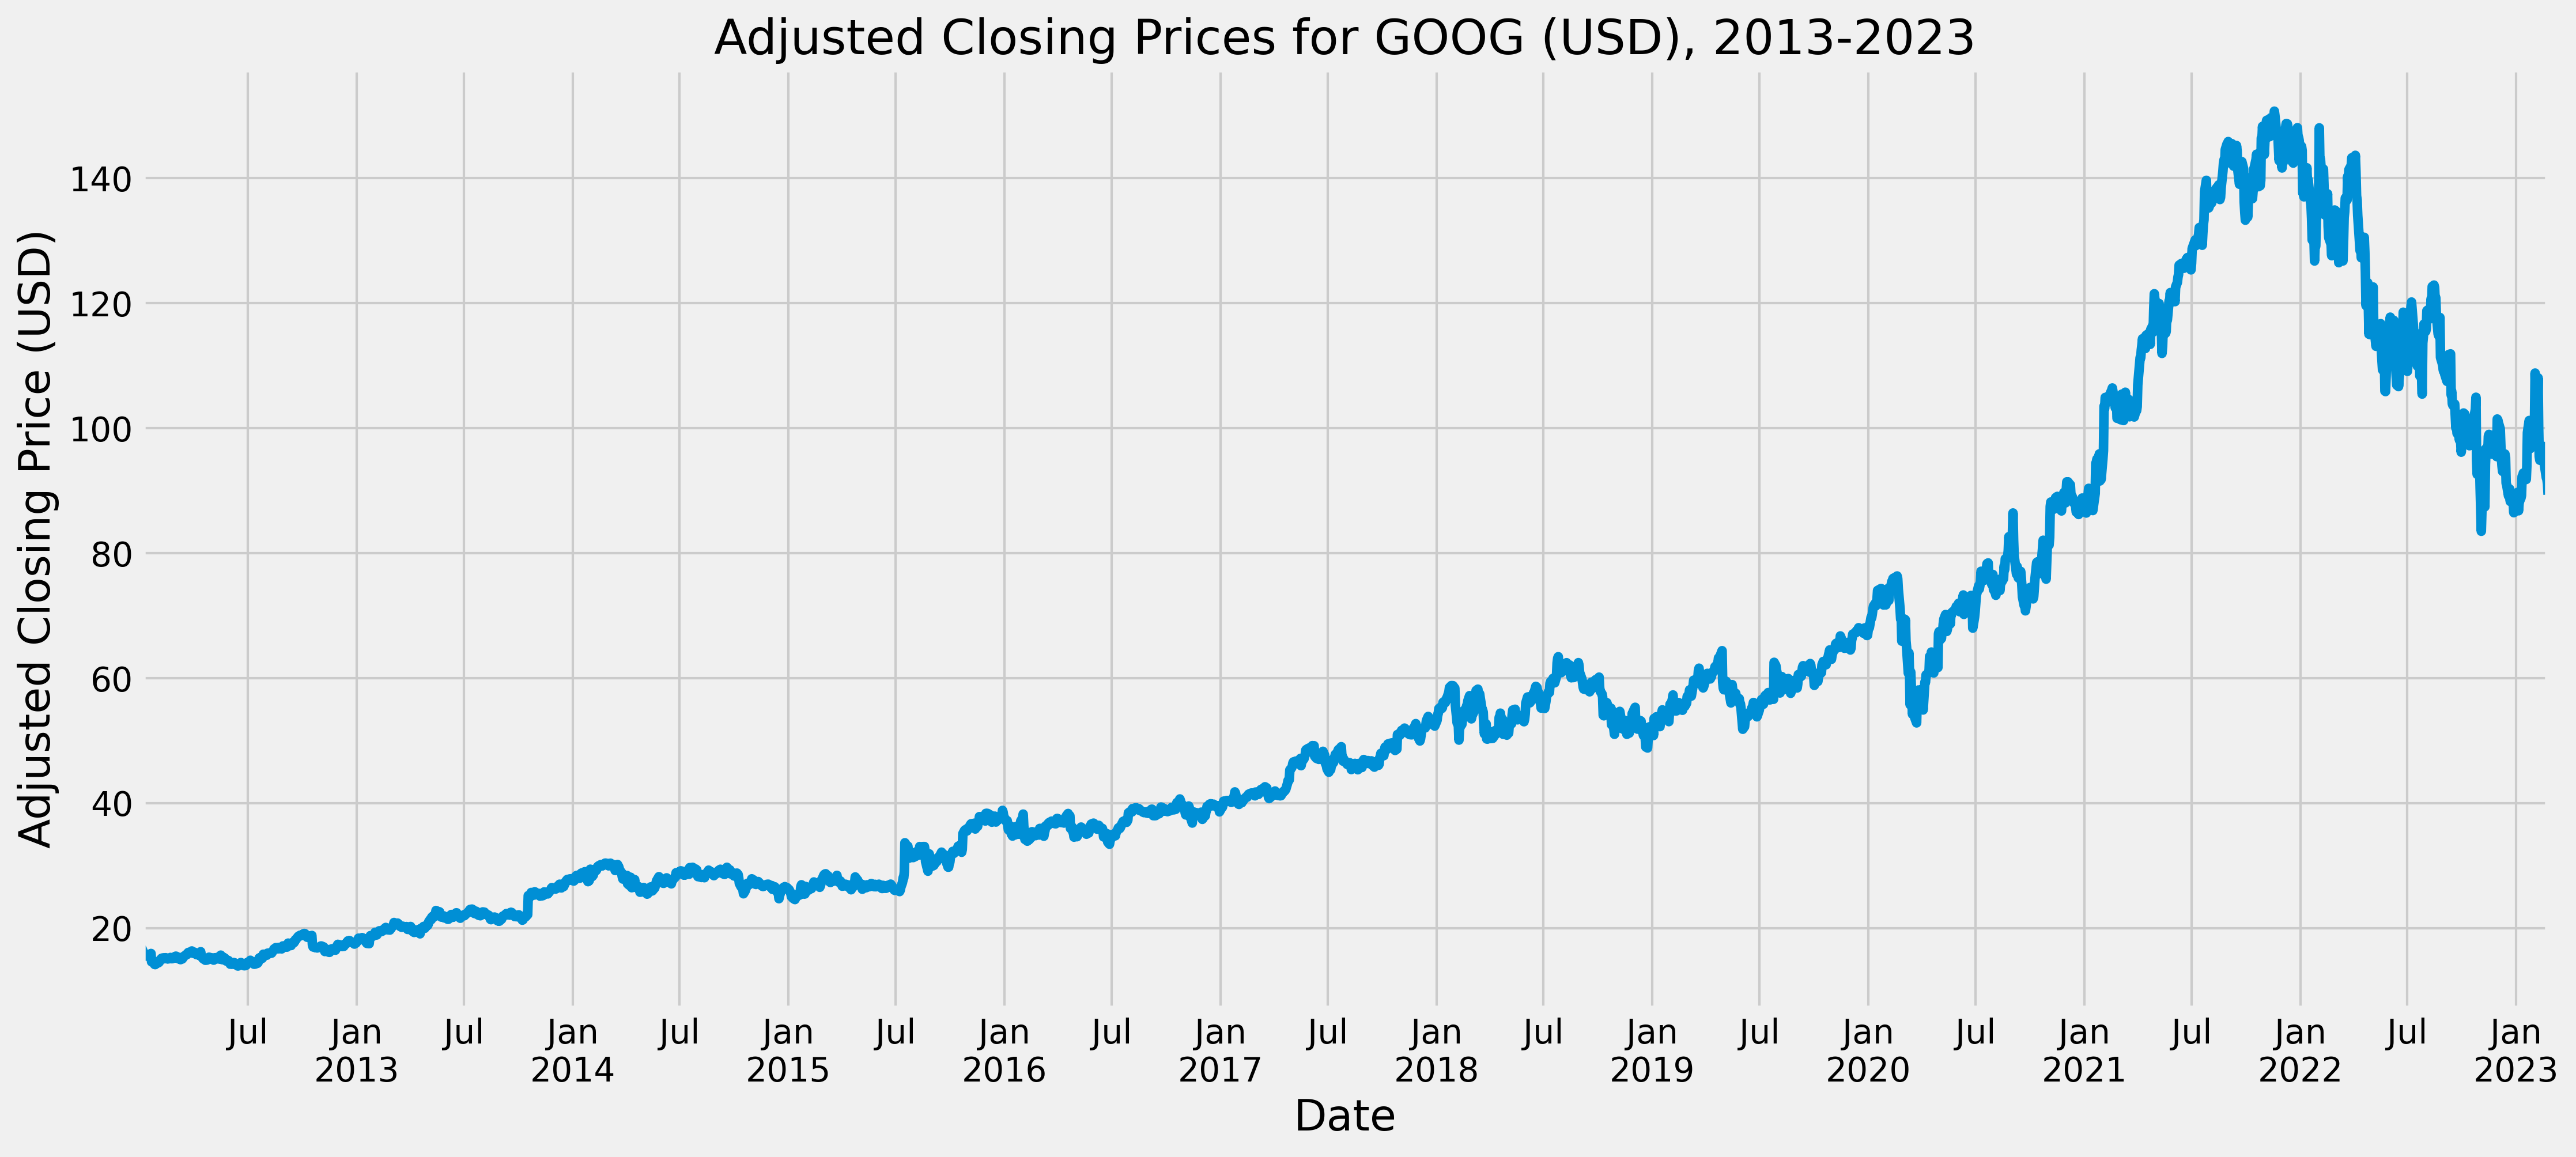

In [36]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose)

ax.set_title('Adjusted Closing Prices for %s (USD), 2013-2023' %tickr)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

### Beta Calculation:<a class="anchor" id="beta"></a>

Using linalg package with roll generator for improved efficiency.

In [14]:
# Obtaining other features: possibilities include CAPE, PE, beta.

# Specify beta (252 = 1yr)
window = 252
market_tickr = 'SPY'

def beta(df, market=None):
    # If the market values are not passed,
    # I'll assume they are located in a column
    # named 'Market'.  If not, this will fail.
    if market is None:
        market = df['MarketClose']
        df = df.drop('MarketClose', axis=1)
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values)
    return float(b[1])

def roll(df, w=252):
    # Takes 'w'-sized slices from dataframe, incrementing 1 entry at a time.
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w],
                           df.columns)


#### Combining stock + market data and computing.
market = pdr.get_data_yahoo(market_tickr,
                            start,
                            end).rename(columns={'Adj Close': 'MarketClose'})

betas = np.array([])
dat = pd.concat([stock.AdjClose, market.MarketClose], axis=1)

for  i, sdf in enumerate(roll(dat.pct_change().dropna(), window)):
    betas = np.append(betas, beta(sdf))

datFull = dat.drop(index=dat.index[:window], axis=0, inplace=False)
datFull['Beta'] = betas.tolist()

[*********************100%***********************]  1 of 1 completed


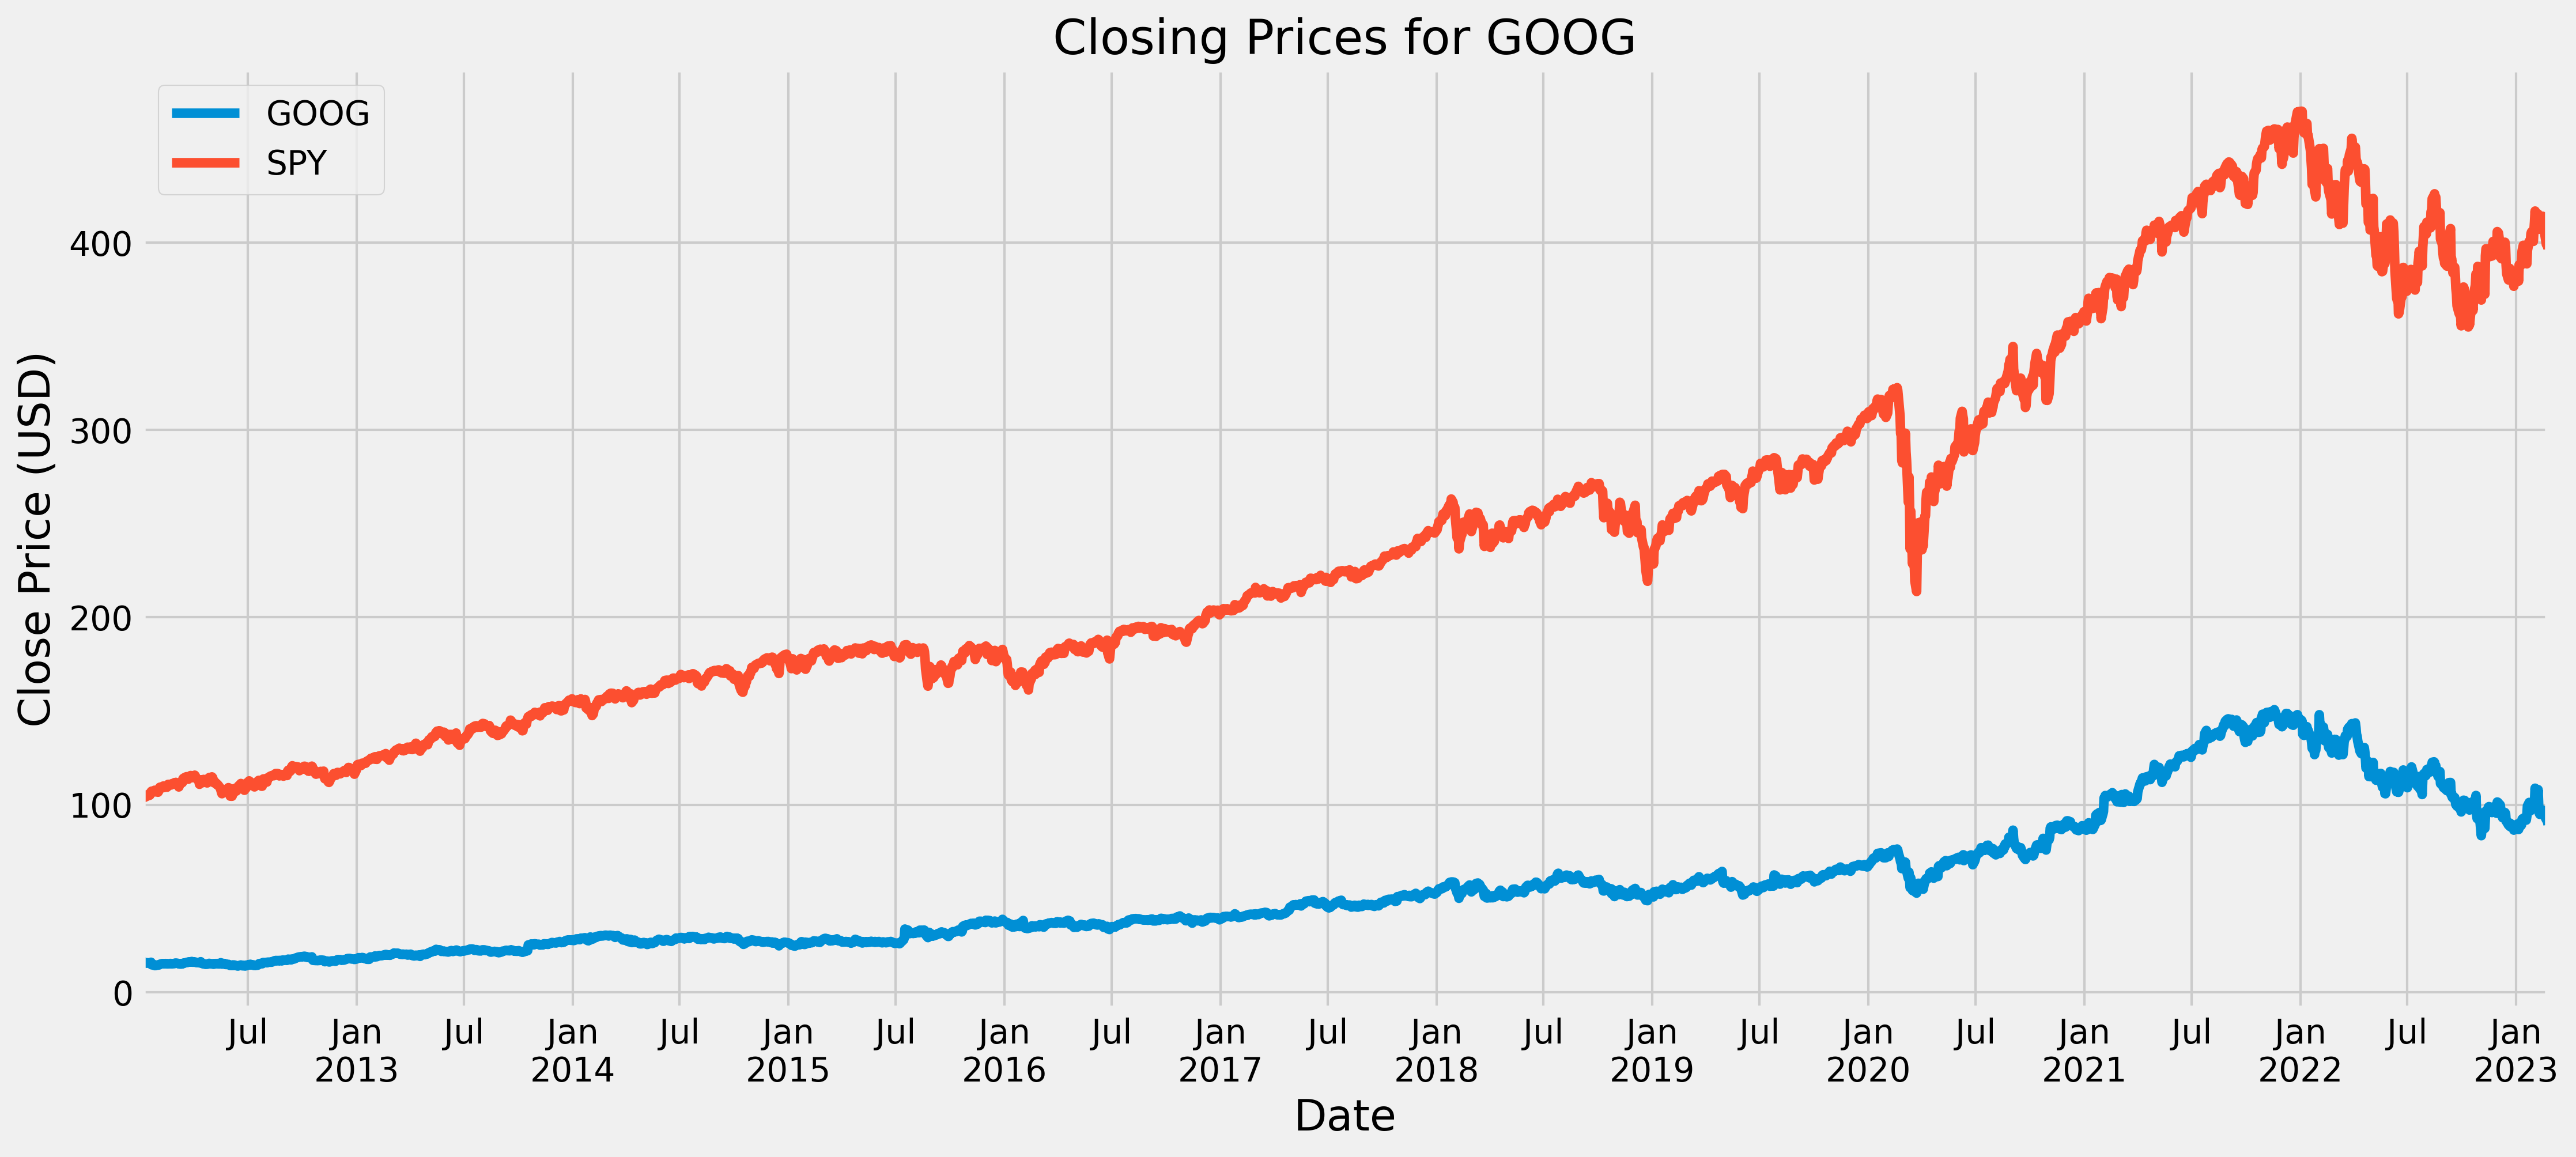

In [15]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose, label=tickr)
ax.plot(market.index, market.MarketClose, label=market_tickr)

ax.set_title('Closing Prices for %s' %tickr)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Close Price (USD)', fontsize=18)
ax.legend()

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

## LSTM Model<a class="anchor" id="lstmmodel"></a>
---

### Preprocessing:<a class="anchor" id="preprocessing"></a>

In [16]:
# consolidating 'Close' prices to one stock.

close = stock.filter(['Close']).values
len_training = math.ceil(len(close) * 0.8)

# scaling data. Ensures quicker convergence to solution.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(close)

# scaled training data.
train_close = scaled_close[0:len_training,:]

x_train = [] # features
y_train = [] # desired prediction

for i in range(60, len(train_close)):
    x_train.append(train_close[i-60:i,0])
    y_train.append(train_close[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Building:<a class="anchor" id="build"></a>

In [47]:
# using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error') # use categorical crossentropy for categories.

### Training Model: <a class="anchor" id="train"></a>

In [48]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-02-26 21:12:42.335078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-26 21:12:42.547526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-26 21:12:42.652416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-26 21:12:42.795401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/2184 [..............................] - ETA: 51:45 - loss: 0.0679

2023-02-26 21:12:43.005608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2184/2184 [==============================] - 66s 29ms/step - loss: 3.6360e-04


In [44]:
# Creating test data w/ scaled values.
test_data = scaled_close[len_training - 60:, :]

x_test = []
y_test = close[len_training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

# reshaping 2d x_test into 3d.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Predictions: <a class="anchor" id="preds"></a>

In [45]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# computing error.
rmse = np.sqrt(np.mean(predictions - y_test)**2)

print("Model error: %.4f" %rmse)

2023-02-26 21:00:42.834127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-26 21:00:42.924365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/18 [=====>........................] - ETA: 0s

2023-02-26 21:00:43.111355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 24ms/step
Model error: 0.8262


/var/folders/5l/9brv6cdn1b97f82knqyjcb4m0000gn/T/ipykernel_3461/1289737578.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


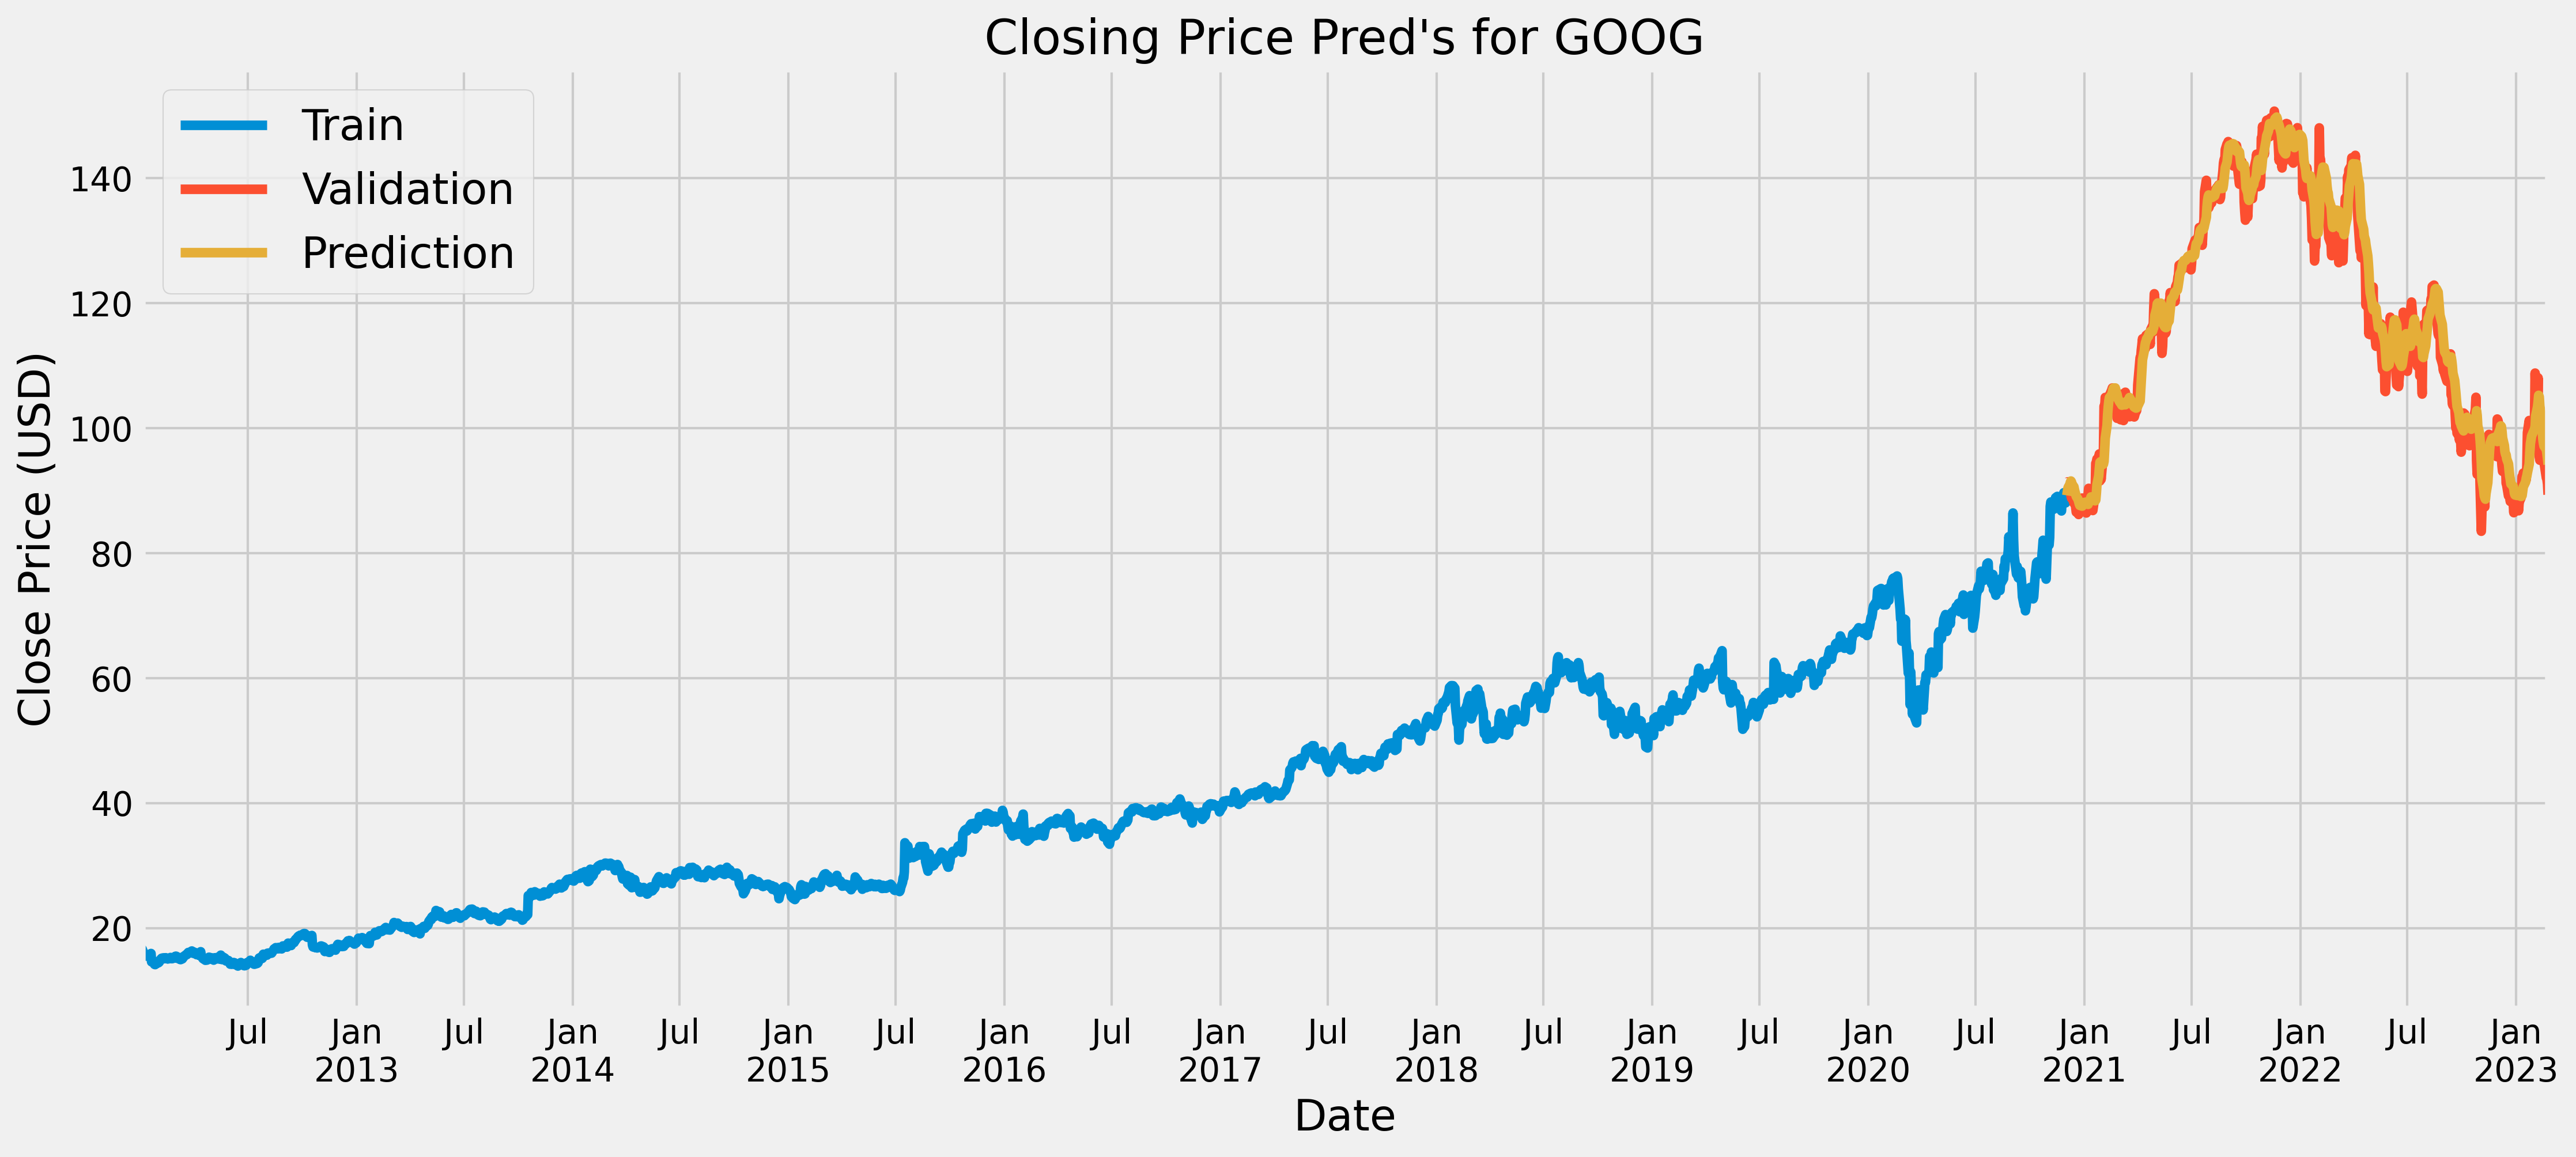

In [46]:
# plotting results.
data = stock.filter(['Close'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions


fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(train.index, train.Close, label='Train')
ax.plot(valid.index, valid.Close, label='Validation')
ax.plot(valid.index, valid.Predictions, label='Prediction')


ax.set_title('Closing Price Pred\'s for %s' %tickr)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Close Price (USD)', fontsize=18)
ax.legend(fontsize='18')

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

In [45]:
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,46.771877
2018-05-18,46.577499,46.721218
2018-05-21,46.907501,46.619030
2018-05-22,46.790001,46.640610
2018-05-23,47.090000,46.646725
...,...,...
2019-12-11,67.692497,64.977287
2019-12-12,67.864998,65.223473
2019-12-13,68.787498,65.466576


### Example 

In [50]:
# making prediction for 18 Dec. 2019.

quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

ex_df = quote.filter(['Close'])

# gets last 60 days of data.
last_60 = ex_df[-60:].values

last_60_scaled = scaler.transform(last_60)


X_test = []
X_test.append(last_60_scaled)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[67.05759]]


---

In [1]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime

import requests_cache

In [2]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = 'DEFAULT_HEADERS'

# Tesla Group 

In [13]:
# scraping stock.
start = '2010-07-29'
end = datetime.datetime.today()
df = pdr.DataReader('TSLA', data_source='yahoo', start=start, end=end)

close = df.filter(['Close']).values
len_training = math.ceil(len(close) * 0.8)

# scaling data.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(close)

# scaled training data.
train_close = scaled_close[0:len_training,:]

x_train = [] # features
y_train = [] # desired prediction

for i in range(60, len(train_close)):
    x_train.append(train_close[i-60:i,0])
    y_train.append(train_close[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# LSTM expectt d1 # of samples, d2 # of timesteps, and d3 # of features.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# compiling.
model.compile(optimizer='adam', loss='mean_squared_error')


# testing.
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_close[len_training - 60:, :]

x_test = []
y_test = close[len_training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

# reshaping 2d x_test into 3d.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/TSLA/history?period1=1280394000&period2=1642327199&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x29717e3a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

/var/folders/5l/9brv6cdn1b97f82knqyjcb4m0000gn/T/ipykernel_13015/389028320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


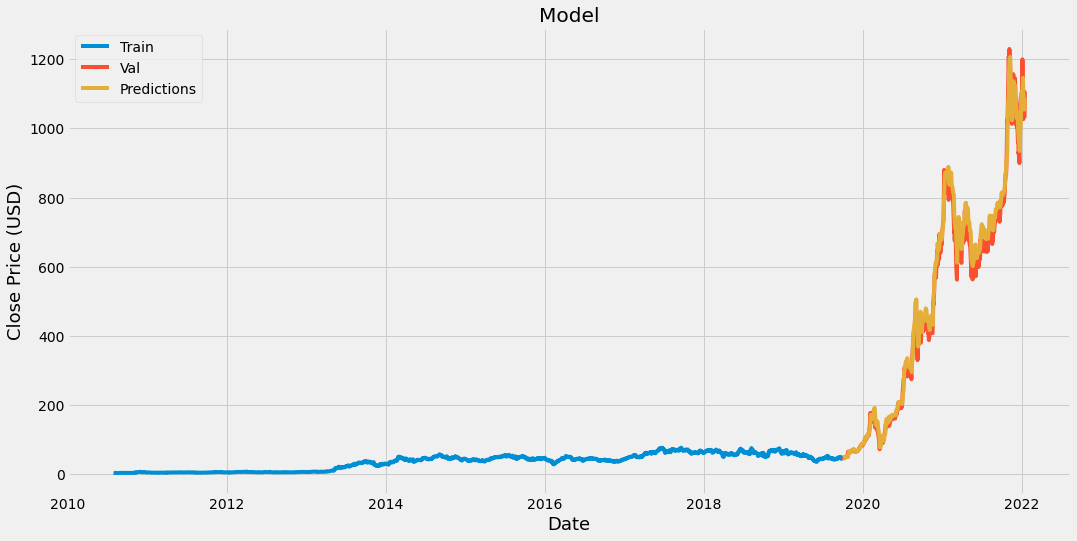

In [15]:
# plotting results.
data = df.filter(['Close'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)

plt.legend(['Train', 'Val', 'Predictions'])

plt.show()

In [12]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

14.934396958640377